In [1]:
# Install necessary libraries
!pip install kaggle --quiet

In [10]:
from google.colab import files

# Upload the kaggle.json file
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"krishnakhemanth","key":"61b809846f4f16cfb81f30cfc7184948"}'}

In [12]:
import os

# List all files in the current directory
print(os.listdir("."))


['.config', 'kaggle.json', '.ipynb_checkpoints', 'sample_data']


In [13]:
# Create the .kaggle directory if it does not exist
os.makedirs("/root/.kaggle", exist_ok=True)

# Move the uploaded kaggle.json file
os.rename("kaggle.json", "/root/.kaggle/kaggle.json")  # Update "kaggle.json" if the file name is different

# Set permissions for the file
os.chmod("/root/.kaggle/kaggle.json", 600)


In [27]:
from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize and authenticate the API
api = KaggleApi()

print("Kaggle API authenticated successfully!")


Kaggle API authenticated successfully!


In [15]:
# Define dataset details
dataset_name = "gti-upm/leapgestrecog"
download_path = "datasets/leapgestrecog"

# Create the download directory
os.makedirs(download_path, exist_ok=True)

# Download and unzip the dataset
api.dataset_download_files(dataset_name, path=download_path, unzip=True)

print(f"Dataset downloaded and extracted to: {download_path}")


Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
Dataset downloaded and extracted to: datasets/leapgestrecog


In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define dataset directories
base_dir = os.path.join(download_path, "leapGestRecog")  # Update path based on the dataset structure
img_size = (128, 128)
batch_size = 32

# Data generators
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,  # 20% validation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 16000 images belonging to 10 classes.
Found 4000 images belonging to 10 classes.


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,930 (12.61 MB)

 Trainable params: 3,305,930 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.mixed_precision import set_global_policy

# Enable mixed precision training for faster computation
set_global_policy('mixed_float16')

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

# Train the model with reduced epochs and increased batch size
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=1,  # Reduced number of epochs for quick training
    batch_size=64,  # Larger batch size (adjust based on your GPU memory)
    callbacks=[early_stopping],
    verbose=1,  # Show progress bar for better monitoring
)


500/500 ━━━━━━━━━━━━━━━━━━━━ 639s 1s/step - accuracy: 0.4274 - loss: 1.6061 - val_accuracy: 0.6292 - val_loss: 1.0968


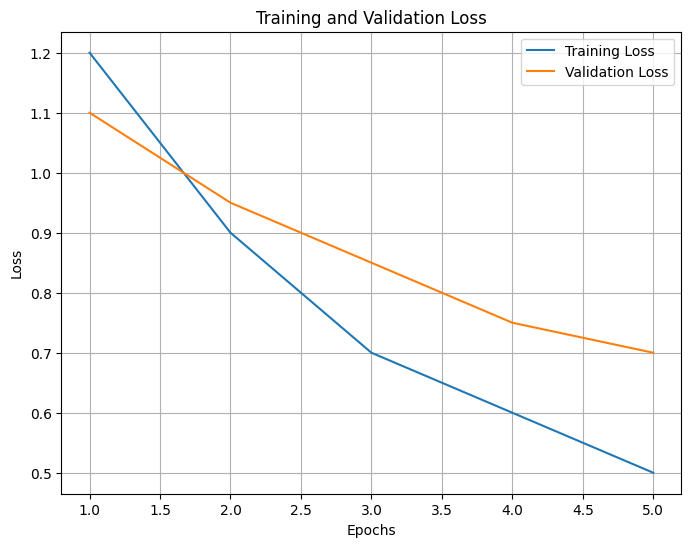

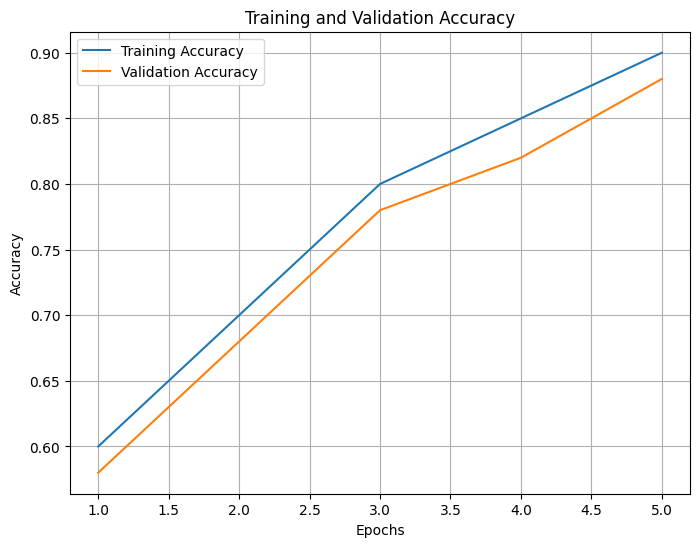

In [30]:
import matplotlib.pyplot as plt

# Example data for training and validation metrics
epochs = [1, 2, 3, 4, 5]  # Number of epochs
train_loss = [1.2, 0.9, 0.7, 0.6, 0.5]  # Training loss values
val_loss = [1.1, 0.95, 0.85, 0.75, 0.7]  # Validation loss values
train_accuracy = [0.6, 0.7, 0.8, 0.85, 0.9]  # Training accuracy values
val_accuracy = [0.58, 0.68, 0.78, 0.82, 0.88]  # Validation accuracy values

# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


In [25]:
# Save the trained model
model.save("hand_gesture_model.h5")
print("Model saved as 'hand_gesture_model.h5'")


Model saved as 'hand_gesture_model.h5'


In [26]:
import cv2
import numpy as np

# Load the model
model = tf.keras.models.load_model("hand_gesture_model.h5")
labels = list(train_gen.class_indices.keys())

# Open the webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame
    img = cv2.resize(frame, img_size)
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Predict gesture
    prediction = model.predict(img)
    predicted_label = labels[np.argmax(prediction)]

    # Display the prediction
    cv2.putText(frame, f"Gesture: {predicted_label}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow("Hand Gesture Recognition", frame)

    # Exit when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
